### Solving Median House Value classification problem implementing a **deep neural network with tanh** and tf.Keras
This experiment shows that a feed-forward deep artificial neural network (at least three hidden layers) with enough hidden neurons, and activation functions that saturate (*tanh*) does not train properly. Any neuron in the third hidden layer receives 10,000 inputs from the previous layer. Therefore, the *net* likely gets very high (in absolute value). The derivative of the *tanh* for a high *net* is close to zero, which makes delta and weights update also close to zero. Going back to the previous layer, there is nothing left to update the weights since the learning algorithm multiplies the derivative of the *tanh* for a high *net* (nearly zero) by the delta values previously calculated, also close to zero. As the algorithm approaches lower layers, the gradient error gets diluted even more, not updating at all their weights. This effect results in small changes in the weigts at the top layers and no changes at all near the input. Different layers learn at different speeds so the final trained neural network converges to a poor local optimum.     


In [ ]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Google file system
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [ ]:
ATT_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValuePreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValueOneHotEncodedClasses.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

x_train: (16342, 9)
t_train: (16342, 3)
x_dev: (2043, 9)
t_dev: (2043, 3)


## Initialization

In [ ]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

Some data is displayed to test correctness:

In [ ]:
x_train[:5]

array([[ 0.21713147, -0.69394261,  0.41176471, -0.93926446, -0.88733706,
        -0.90924634, -0.89278079, -0.77585137, -1.        ],
       [-0.69322709,  0.17747078, -0.29411765, -0.91795107, -0.88671633,
        -0.95448303, -0.88949186, -0.59159184,  1.        ],
       [ 0.44820717, -0.95961743,  0.37254902, -0.8306628 , -0.80074488,
        -0.89349477, -0.79575728, -0.5589716 ,  1.        ],
       [ 0.29083665, -0.7088204 , -0.41176471, -0.87629076, -0.85909373,
        -0.94315984, -0.84377569, -0.48705535, -1.        ],
       [-0.40039841,  0.15834219, -0.49019608, -0.8418536 , -0.84574798,
        -0.93413493, -0.82765992, -0.16468738, -0.33333333]])

In [ ]:
t_train[:10]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
x_dev[:5]

array([[ 0.22908367, -0.67906482,  0.45098039, -0.83366397, -0.77343265,
        -0.81524146, -0.76155238, -0.67868029, -1.        ],
       [-0.61752988,  0.10308183,  1.        , -0.94201129, -0.93078833,
        -0.97247681, -0.93257688, -0.37100178,  0.33333333],
       [-0.39043825,  0.16046759, -0.88235294, -0.92929447, -0.90037244,
        -0.90016536, -0.89870087, -0.74136908, -0.33333333],
       [-0.24701195, -0.45377258, -0.33333333, -0.85156926, -0.82774674,
        -0.94030102, -0.81877981, -0.58286093, -1.        ],
       [ 0.22908367, -0.73645058, -0.25490196, -0.90589552, -0.82774674,
        -0.90420135, -0.81746423, -0.86805699,  1.        ]])

In [ ]:
t_dev[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Hyperparameters

The number of hidden layers and neurons per layer must be adjusted. In this example, we try to increase the computational power of the neural network by adding up to three hidden layers (to be deep) and more neurons per layer. 

In [ ]:
n_epochs = 600 # corresponding to about 20,000 iterations
learning_rate = 0.1
batch_size = 500
n_neurons_per_hlayer = [10000,10000, 10000] 

## Build the deep neural model

First of all, a sequential model is created. This is the one of Keras models, for full-connected feedforward neural networks, in which layers are sequentially connected. This is called the *sequential* API.

In [ ]:
model = keras.Sequential(name="Feedforward NN")

Define the deep neural network topology. Note that the **tanh** activation function is chosen for the hidden layers and  **softmax** for the ouput layer. **We expect that the neural network does not train properly since we are employing an activation function that saturates at its tails**. 

Adding layers to the model. The model takes as input matrix tensors with *INPUTS* columns and any number of rows. *InputLayer* creates a placeholder where the data is ready to feed the network. Then the hidden layers with *tanh* activation function are created. Finally, the output layer with the *softmax* activation function is added. 

In [ ]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, activation="tanh"))

model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Feedforward NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10000)             100000    
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             100010000 
_________________________________________________________________
dense_2 (Dense)              (None, 10000)             100010000 
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 30003     
Total params: 200,150,003
Trainable params: 200,150,003
Non-trainable params: 0
_________________________________________________________________


Two hundred million parameters to adjust. For example, the kernel in the last layer comprises 30,003 parameters: 10,000 neurons in the previous layer by 3 neurons in the output layer plus the three biases, one for each output neuron. 

This experiment could not be conducted some time ago due to a lack of computational resources. The difficulties in training deep neural networks could only be devised from mathematical analysis.   

In [ ]:
model.layers

In [ ]:
for l in model.layers: print (l.name)

dense
dense_1
dense_2
dense_3


All the parameters of a layer can bee accessed:

In [ ]:
weights, biases = model.layers[0].get_weights()
weights.shape

(9, 10000)

In [ ]:
biases

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
biases.shape

(10000,)

# Compiling the model

Compiling the model means specifying the *loss* function (the $log-loss$,  $cross-entropy$, the sum of log-loss is a loss) and the *optimizer* (Gradient Descent) to use. Optionally, you can also specify a list of extra *metrics* (Accuracy) to compute during training and evaluation. In this case, 

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=learning_rate),
              metrics=["categorical_accuracy"])


There are several losses functions, optimizers and metrics. Full lists are available at: https://keras.io/losses/, https://keras.io/optimizers/ and https://keras.io/metrics/.


## Training and validating the model with M-BGD

Note that an **epoch** is an iteration over the entire training dataset provided.

In [ ]:
import time
start = time.clock()
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(x_dev, t_dev))    
print (time.clock() - start)

Train on 16342 samples, validate on 2043 samples
Epoch 1/600
16342/16342 [==============================] - 12s 741us/sample - loss: 0.9901 - categorical_accuracy: 0.5269 - val_loss: 1.1185 - val_categorical_accuracy: 0.3671
Epoch 2/600
16342/16342 [==============================] - 11s 700us/sample - loss: 0.8802 - categorical_accuracy: 0.5799 - val_loss: 0.7695 - val_categorical_accuracy: 0.6559
Epoch 3/600
16342/16342 [==============================] - 11s 701us/sample - loss: 0.8265 - categorical_accuracy: 0.6015 - val_loss: 0.8274 - val_categorical_accuracy: 0.5952
Epoch 4/600
16342/16342 [==============================] - 12s 706us/sample - loss: 0.8156 - categorical_accuracy: 0.6102 - val_loss: 0.7248 - val_categorical_accuracy: 0.6735
Epoch 5/600
16342/16342 [==============================] - 11s 700us/sample - loss: 0.7693 - categorical_accuracy: 0.6425 - val_loss: 0.7251 - val_categorical_accuracy: 0.6691
Epoch 6/600
16342/16342 [==============================] - 12s 705us/sa

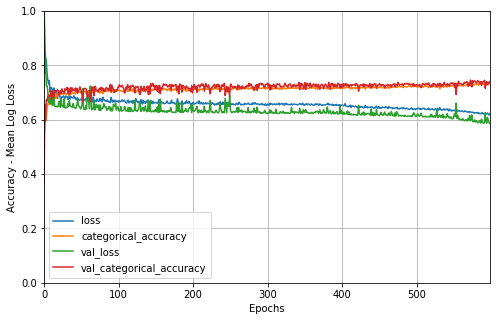

In [ ]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Note how the learning curves are plain. BP learning algorithm converges slowly or to a poor local optimum. 

In [ ]:
history.params

{'batch_size': 500,
 'do_validation': True,
 'epochs': 600,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy'],
 'samples': 16342,
 'steps': None,
 'verbose': 0}

In [ ]:
results[-1:]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
599,0.616998,0.73253,0.587924,0.737151


In [ ]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

Accuracy for the training set:  0.7325296998023987


In [ ]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.7371512651443481


Now the accuracy is 73% on training and 73% on the develoment test set, worse than those achieved with just one hidden layer with 1,000 neurons. Moreover, the training process takes 83 minutes to accomplish 600 epochs, about 20,000 iterations with a batch size of 500.   

Let's see how the model predicts on the development test set:

In [ ]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]


array([[0.35, 0.61, 0.05],
       [0.  , 0.06, 0.94],
       [0.91, 0.09, 0.  ],
       [0.02, 0.29, 0.69],
       [0.71, 0.26, 0.03],
       [0.02, 0.5 , 0.47],
       [0.01, 0.38, 0.61],
       [0.  , 0.05, 0.95],
       [0.  , 0.  , 1.  ],
       [0.74, 0.24, 0.02],
       [0.15, 0.74, 0.11],
       [0.42, 0.51, 0.07],
       [0.4 , 0.48, 0.12],
       [0.33, 0.48, 0.18],
       [0.91, 0.09, 0.  ],
       [0.01, 0.1 , 0.9 ],
       [0.92, 0.07, 0.  ],
       [0.  , 0.05, 0.95],
       [0.1 , 0.7 , 0.2 ],
       [0.  , 0.02, 0.98]], dtype=float32)

In [ ]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
t_dev[:20] #target classes

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(t_dev,1))
print (dev_correct_predictions[:30])

[False  True  True False False  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True]


In [ ]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({False: 539, True: 1504})

Obviously, this model makes more mistakes than the one-hidden layer neural network with 1,000 neurons.   